# Excercise_2 : T-SNE Visualisation on Amazon Fine Food Review Dataset.

**OBJECTIVE :**
To perform T-SNE visualisation on the Amazon fine food review dataset with various text to vector techniques,
1. Bag-Of-Words
2. Tf-Idf
3. Average Word2Vector
4. Tf-Idf weighted Word2Vector.

Steps:
1. Text Preprocessing .
2. Converting text to vectors using a technique.
3. Standardising the matrix.
4. Converting into dense matrix, and dimensionality reduction.
5. T-SNE visulisation.

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# 1. Text Preprocessing.

Steps:

1. Removing html tags.
2. Removing punctuations.
3. Removing the non-alphanumeric and words with length less than 2.
4. Converting the words to lowercase.
5. Removing Stopwords.
6. Performing Stemming usng Snowball Stemming.

In [0]:
# Importing the dataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Code snippet from Amazon_fine_food_review.ipynb.

con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con,coerce_float=True) 

def partition(x):
    if x < 3:
        return 0
    return 1

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')              #compiles a pattern.
    cleantext = re.sub(cleanr, ' ', sentence) #replaces cleanr with '' in sentence.
    return cleantext
  
  #function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

#**************TEXT-PREPROCESSING********
if not os.path.isfile('final.sqlite'):   #if final.sqlite doesnt exist run the following commmands.

    i=0
    str1=' '
    final_string=[]  #For storing the final cleaned string.
    
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    
    # for loop loops one review at a time
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        sent=cleanhtml(sent) # remove HTMl tags
        
        #this loops through the review
        for w in sent.split(): #split creates a list of the words in the sentence.
            for cleaned_words in cleanpunc(w).split():    #each word is  cleared-punctuation & taken as a individual list.
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    #if the list(word) is alpha and size < 2 
                    if(cleaned_words.lower() not in stop):              # if it is not a stopword. 
                        s=( sno.stem( cleaned_words.lower() ) ).encode('utf8')
                        filtered_sentence.append(s)                            
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #converts list into a final string of cleaned words(in bytes)

        final_string.append(str1)
        i+=1
        
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")

    # storing the df into a new sqlite file.
    conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()


**Observations: **
1. A dataframe with scores != 3 is created, scores are converted to 1s,0s.
2. Data is deduplicated.
3. Data is text-preprocessed(Removing html-tags,punctuation,stop-words,converting to lower-case,snowball-stemming)
2. The text is preprocessed and the processed dataframe is stored in a sql file final.sqlite

In [0]:
#Loading the processed data into a dataframe final.

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/final.sqlite'):
    conn = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/final.sqlite')
    finale = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [0]:
# A dataframes of random samples of 100 positive and negative reviews is created.

final_pos = finale[finale['Score'] == 1].sample(n = 1000)
final_neg = finale[finale['Score'] == 0].sample(n = 1000)

In [0]:
#concatenating the dataframes.
df = pd.concat([final_pos,final_neg],ignore_index=True,axis=0)

#with open('/content/drive/My Drive/Colab Notebooks/sample_2k.pkl','wb') as f:
 # pickle.dump(df,f)

Observation:
  1. Storing the sampled dataset into a pickle file to use it in other technique.

# Bag-Of-Words.

In [0]:
# Bagofwords module from scikit-learn.
count_vect = CountVectorizer() #in scikit-learn
final = count_vect.fit_transform(df['CleanedText'].values)  #returns vectors of the reviews. vectors are size of #unique words.

In [0]:
final.shape

(2000, 6661)

In [0]:
# Standardising the dataset.

standardized_data = StandardScaler(with_mean=False).fit_transform(final)
print(standardized_data.shape)

(2000, 6661)


In [0]:
standardized_data = standardized_data.todense()

In [0]:
standardized_data.shape

(2000, 6661)

# T-SNE Visualisation

In [0]:
# Creating a tsne model.

model = TSNE(n_components=2,perplexity=50,random_state=0)

In [0]:
#Training the model.
tsne_data = model.fit_transform(standardized_data)

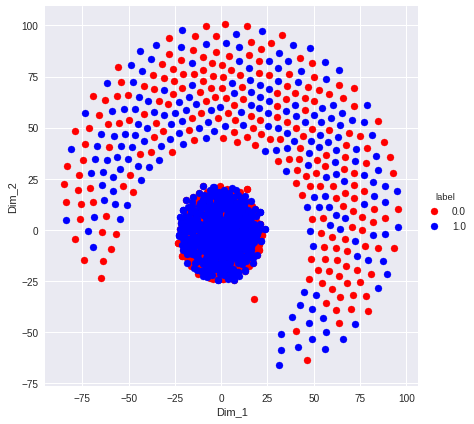

In [0]:
#Creating a dataframe of the t-sne data and the labels for visualisation.

labels = df['Score']

tsne = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne, columns=("Dim_1", "Dim_2", "label"))

sn.FacetGrid(tsne_df, hue="label",palette=['r','b'] ,size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF

In [0]:
#Tf-idf using 1,2-grams

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(df['CleanedText'].values)

In [0]:
#Standardising the dataset.

standardized_data_2 = StandardScaler(with_mean=False).fit_transform(final_tf_idf)
print(standardized_data_2.shape)

(2000, 67759)


In [0]:
scaled_data_2= standardized_data_2.todense()

In [0]:
labels = df['Score']

#create a model.
model_2 = TSNE(n_components=2,perplexity=100,n_iter=1000, random_state=0)

In [0]:
#training the model

tsne_data_2 = model_2.fit_transform(scaled_data_2)

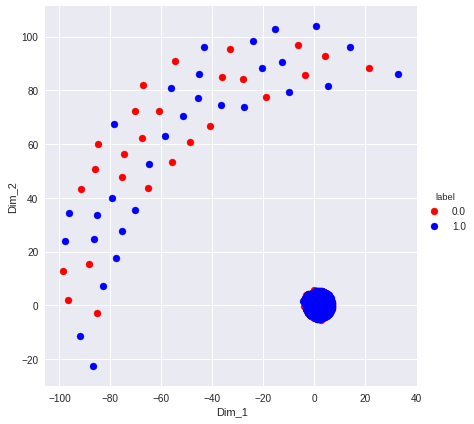

In [0]:
#creating the dataframe of tsne data and labels.

tsne_2 = np.vstack((tsne_data_2.T, labels)).T
tsne_df_2 = pd.DataFrame(data=tsne_2, columns=("Dim_1", "Dim_2", "label"))

sn.FacetGrid(tsne_df_2, hue="label",palette=['r','b'], size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# AverageWord2Vector T-SNE

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in df['CleanedText'].values:
    list_of_sent.append(sent.split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
len(w2v_words)

2038

In [0]:
# average Word2Vec

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sent): # for each review/sentence
   
    sent_vec = np.zeros(50) # as word vectors are of zero length
    
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]   #for each word a ector is created
            sent_vec += vec            #each vector is added
            cnt_words += 1             #count of words in the review
    if cnt_words != 0:
        sent_vec /= cnt_words          # sum(word_vectors) / #words
    sent_vectors.append(sent_vec)      #sent_vectors - list of vectors of reviews



100%|██████████| 2000/2000 [00:01<00:00, 1226.83it/s]


In [0]:
#creating a dataframe of the sentence vectors
w2v_df = pd.DataFrame(sent_vectors)

In [0]:
#standardising the data.

standardized_data_3 = StandardScaler().fit_transform(w2v_df)
print(standardized_data_3.shape)

(2000, 50)


In [0]:
#create a model
model_3= TSNE(n_components=2,perplexity=150,n_iter=5000, random_state=0)


In [0]:
#Training the model
tsne_data_3 = model_3.fit_transform(standardized_data_3)

In [0]:
# accesing the label columns in the text dataframe.
labels = df['Score']

#creating the dataframe of tsne data and labels.

tsne_3 = np.vstack((tsne_data_3.T, labels)).T
tsne_df_3 = pd.DataFrame(data=tsne_3, columns=("Dimension_1", "Dimension_2", "label"))

In [0]:
tsne_df.shape

(2000, 3)

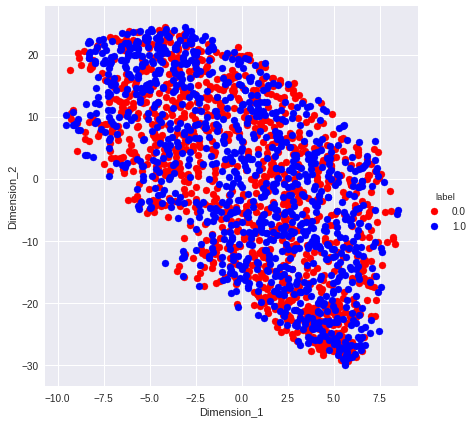

In [0]:
#Graphing the tsne data.

sn.FacetGrid(tsne_df_3, hue="label",palette=['r','b'],size=6).map(plt.scatter, 'Dimension_1', 'Dimension_2').add_legend()
plt.show()

# TF-IDF Weighed Word2Vector T-SNE

In [0]:
# Creating a tf-idf model.

model_4 = TfidfVectorizer()
tf_idf_matrix = model_4.fit_transform(df['CleanedText'].values)

# creating a dictionary of words and its idf values.
dictionary = dict(zip(model_4.get_feature_names(), list(model_4.idf_)))

In [0]:
# Creating a lists of vectors of sentences where each row if tfidf*w2v/sum(tfidf).

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

for sent in tqdm(list_of_sent): # for each review/sentence 
    
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; 
    
    for word in sent: # for each word in a review/sentence
      
        if word in w2v_words:#if word in vocab
            vec = w2v_model.wv[word]#create a vec for the word.

            tf_idf = dictionary[word]*(sent.count(word)/len(sent)) # idf * tf
            
            sent_vec += (vec * tf_idf) #w2v * tf-idf 
            
            weight_sum += tf_idf
            
    if weight_sum != 0:
      
        sent_vec /= weight_sum  #(E(w2v * tf-idf)/ E(tf-idf))
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 2000/2000 [00:02<00:00, 935.73it/s]


In [0]:
tfidfw2v_df = pd.DataFrame(tfidf_sent_vectors)

In [0]:
from sklearn.preprocessing import StandardScaler
standardized_data_4 = StandardScaler().fit_transform(tfidfw2v_df)
print(standardized_data_4.shape)

(2000, 50)


In [0]:
#create a model.
model_4 = TSNE(n_components=2,perplexity=200, random_state=0)

In [0]:
#training the model
tsne_data_4 = model_4.fit_transform(standardized_data_4)

In [0]:
#creating the dataframe of tsne data and labels.

labels = df['Score']

tsne_4 = np.vstack((tsne_data_4.T, labels)).T 
tsne_df_4 = pd.DataFrame(data=tsne_4, columns=("Dim_1", "Dim_2", "label"))

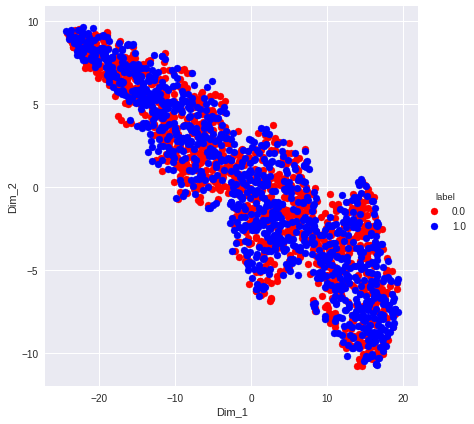

In [0]:
sn.FacetGrid(tsne_df_4, hue="label",palette=['r','b'], size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()